![CTA first data challenge logo](images/cta-1dc.png)

# CTA data analysis with Gammapy

## Introduction

**This notebook shows an example how to make a sky image and spectrum for simulated CTA data with Gammapy.**

The dataset we will use is three observation runs on the Galactic center. This is a tiny (and thus quick to process and play with and learn) subset of the simulated CTA dataset that was produced for the first data challenge in August 2017.

**This notebook can be considered part 2 of the introduction to CTA 1DC analysis. Part one is here: [cta_1dc_introduction.ipynb](cta_1dc_introduction.ipynb)**

## Setup

As usual, we'll start with some setup ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Check package versions, if something goes wrong here you won't be able to run the notebook
import gammapy
import numpy as np
import astropy
import regions
import sherpa
import uncertainties
import photutils

print('gammapy:', gammapy.__version__)
print('numpy:', np.__version__)
print('astropy:', astropy.__version__)
print('regions:', regions.__version__)
print('sherpa:', sherpa.__version__)
print('uncertainties:', uncertainties.__version__)
print('photutils:', photutils.__version__)

gammapy: 0.7.dev5344
numpy: 1.13.3
astropy: 3.0.dev20763
regions: 0.2
sherpa: 4.9.1+12.g3626715
uncertainties: 2.4.8.1
photutils: 0.3.2


In [3]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from photutils.detection import find_peaks
from gammapy.data import DataStore
from gammapy.spectrum import (
    SpectrumExtraction,
    SpectrumFit,
    SpectrumResult,
    models,
    SpectrumEnergyGroupMaker,
    FluxPointEstimator,
)
from gammapy.image import SkyImage, IACTBasicImageEstimator
from gammapy.background import RingBackgroundEstimator, ReflectedRegionsBackgroundEstimator
from gammapy.utils.energy import EnergyBounds
from gammapy.detect import TSImageEstimator

In [4]:
# Configure the logger, so that the spectral analysis
# isn't so chatty about what it's doing.
import logging
logging.basicConfig()
log = logging.getLogger('gammapy.spectrum')
log.setLevel(logging.ERROR)

## Select observations

Like explained in [cta_1dc_introduction.ipynb](cta_1dc_introduction.ipynb), a Gammapy analysis usually starts by creating a `DataStore` and selecting observations.

This is shown in detail in the other notebook, here we just pick three observations near the galactic center.

In [5]:
data_store = DataStore.from_dir('$CTADATA/index/gps')

In [6]:
# Just as a reminder: this is how to select observations
# from astropy.coordinates import SkyCoord
# table = data_store.obs_table
# pos_obs = SkyCoord(table['GLON_PNT'], table['GLAT_PNT'], frame='galactic', unit='deg')
# pos_target = SkyCoord(0, 0, frame='galactic', unit='deg')
# offset = pos_target.separation(pos_obs).deg
# mask = (1 < offset) & (offset < 2)
# table = table[mask]
# table.show_in_browser(jsviewer=True)

In [7]:
obs_id = [110380, 111140, 111159]
obs_list = data_store.obs_list(obs_id)

In [8]:
obs_cols = ['OBS_ID', 'GLON_PNT', 'GLAT_PNT', 'LIVETIME']
data_store.obs_table.select_obs_id(obs_id)[obs_cols]

OBS_ID,GLON_PNT,GLAT_PNT,LIVETIME
int64,float64,float64,float64
110380,359.999991204,-1.29999593791,1764.0
111140,358.499983383,1.3000020212,1764.0
111159,1.50000565683,1.29994046834,1764.0


## Make sky images

### Define map geometry

Select the target position and define an ON region for the spectral analysis

In [9]:
target_position = SkyCoord(0, 0, unit='deg', frame='galactic')
on_radius = 0.2 * u.deg
on_region = CircleSkyRegion(center=target_position, radius=on_radius)

In [10]:
# Define reference image centered on the target
xref = target_position.galactic.l.value
yref = target_position.galactic.b.value
# size = 10 * u.deg
# binsz = 0.02 # degree per pixel
# npix = int((size / binsz).value)

ref_image = SkyImage.empty(
    nxpix=800, nypix=600, binsz=0.02,
    xref=xref, yref=yref,
    proj='TAN', coordsys='GAL',
)
print(ref_image)

Name: None
Data shape: (600, 800)
Data type: float64
Data unit: 
Data mean: 0.000e+00
WCS type: ['GLON-TAN', 'GLAT-TAN']



### Compute images

We use the ring background estimation method, and an exclusion mask that excludes the bright source at the Galactic center.

(<matplotlib.figure.Figure at 0x10443af98>,
 None)

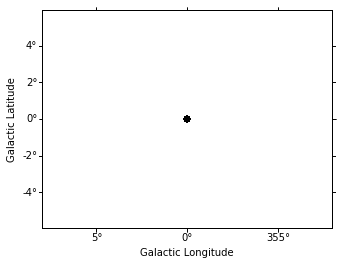

In [11]:
exclusion_mask = ref_image.region_mask(on_region)
exclusion_mask.data = 1 - exclusion_mask.data
exclusion_mask.plot()

In [12]:
bkg_estimator = RingBackgroundEstimator(
    r_in=0.5 * u.deg,
    width=0.2 * u.deg,
)
image_estimator = IACTBasicImageEstimator(
    reference=ref_image,
    emin=100 * u.GeV,
    emax=100 * u.TeV,
    offset_max=3 * u.deg,
    background_estimator=bkg_estimator,
    exclusion_mask=exclusion_mask,
)
images = image_estimator.run(obs_list)
images.names

/Users/deil/code/gammapy/gammapy/cube/core.py:76: RuntimeWarning: divide by zero encountered in log
  log_data = np.log(self.data.value)
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:2477: RuntimeWarning: invalid value encountered in multiply
  values += np.asarray(self.values[edge_indices]) * weight[vslice]


['counts', 'exposure', 'background', 'excess', 'flux', 'psf']

### Show images

Let's define a little helper function and then show all the resulting images that were computed.

In [13]:
def show_image(image, radius=3, vmin=0, vmax=3):
    """Little helper function to show the images for this application here."""
    image.smooth(radius=radius).show(vmin=vmin, vmax=vmax, add_cbar=True)
    image.cutout(
        position=SkyCoord(0.5, 0, unit='deg', frame='galactic'),
        size=(2*u.deg, 3*u.deg),
    ).smooth(radius=radius).show(vmin=vmin, vmax=vmax, add_cbar=True)

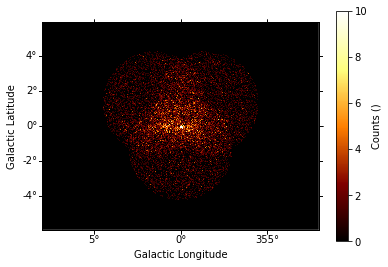

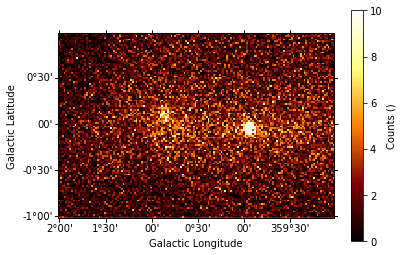

In [14]:
show_image(images['counts'], radius=0, vmax=10)

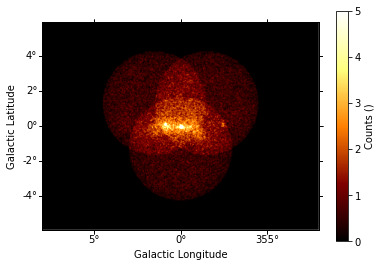

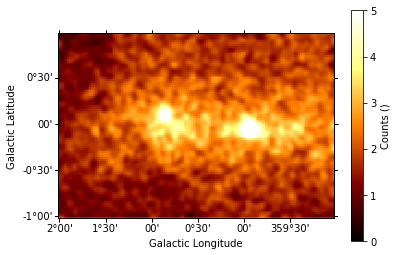

In [15]:
show_image(images['counts'], vmax=5)

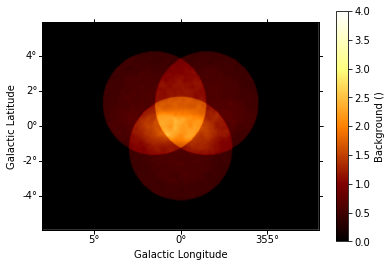

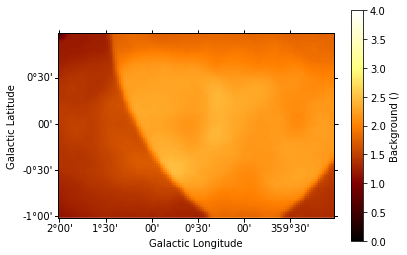

In [16]:
show_image(images['background'], vmax=4)

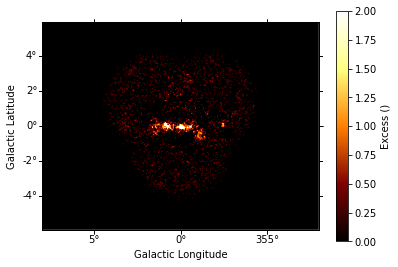

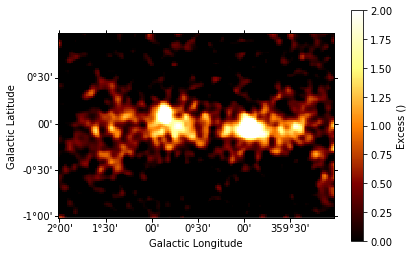

In [17]:
show_image(images['excess'], vmax=2)

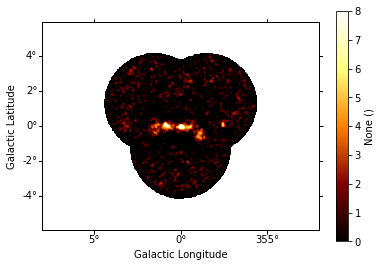

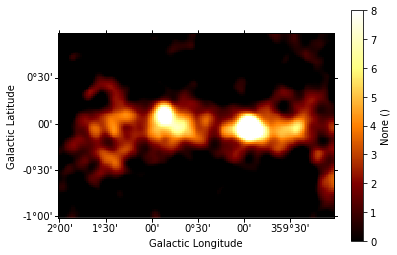

In [18]:
# Significance image
# Just for fun, let's compute it by hand ...
from astropy.convolution import Tophat2DKernel
kernel = Tophat2DKernel(4)
kernel.normalize('peak')

counts_conv = images['counts'].convolve(kernel.array)
background_conv = images['background'].convolve(kernel.array)

from gammapy.stats import significance
significance_image = SkyImage.empty_like(ref_image)
significance_image.data = significance(counts_conv.data, background_conv.data)
show_image(significance_image, vmax=8)

## Source Detection

Use the class [TSImageEstimator](http://docs.gammapy.org/en/latest/api/gammapy.detect.compute_ts_image.html#gammapy.detect.TSImageEstimator.html) and [photutils.find_peaks](http://photutils.readthedocs.io/en/stable/api/photutils.find_peaks.html) to detect point-like sources on the images:

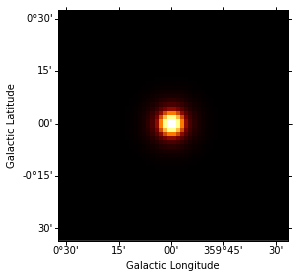

In [19]:
# cut out smaller piece of the PSF image to save computing time
# for covenience we're "misusing" the SkyImage class represent the PSF on the sky.
kernel = images['psf'].cutout(target_position, size= 1.1 * u.deg)
kernel.show()

In [20]:
ts_image_estimator = TSImageEstimator()
images_ts = ts_image_estimator.run(images, kernel.data)
print(images_ts.names)

['ts', 'sqrt_ts', 'flux', 'flux_err', 'flux_ul', 'niter']


In [21]:
# find pointlike sources with sqrt(TS) > 5
sources = find_peaks(data=images_ts['sqrt_ts'].data, threshold=5, wcs=images_ts['sqrt_ts'].wcs)
sources

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/photutils/detection/core.py:241: RuntimeWarning: invalid value encountered in greater
  peak_goodmask = np.logical_and(peak_goodmask, (data > threshold))


x_peak,y_peak,icrs_ra_peak,icrs_dec_peak,peak_value
,,deg,deg,
int64,int64,float64,float64,float64
451,269,266.386490097,-30.1329751991,6.43453671617
328,279,267.643982436,-27.923799443,5.01020960141
457,279,266.116882008,-30.1308815126,6.99895391199
420,295,266.248069224,-29.332923145,7.40642882084
319,296,267.418588423,-27.5950146565,5.43758078846
403,296,266.431608887,-29.0323948208,31.2056071515
328,297,267.294781246,-27.7389955437,6.11383181087
428,297,266.112959439,-29.4484139711,8.3317349187


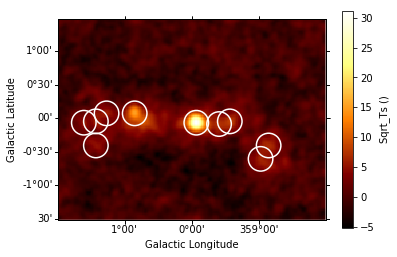

In [22]:
# Plot sources on top of significance sky image
images_ts['sqrt_ts'].cutout(
    position=SkyCoord(0, 0, unit='deg', frame='galactic'),
    size=(3*u.deg, 4*u.deg)
).plot(add_cbar=True)

plt.gca().scatter(
    sources['icrs_ra_peak'], sources['icrs_dec_peak'],
    transform=plt.gca().get_transform('icrs'),
    color='none', edgecolor='white', marker='o', s=600, lw=1.5,
)

## Spatial analysis

To do a spatial analysis of the data, you can pass the `counts`, `exposure` and `background` image, as well as the `psf` kernel to Sherpa and use Sherpa to fit spatial models.

We plan to add an example to this notebook.

For now, please see [image_fitting_with_sherpa.ipynb](image_fitting_with_sherpa.ipynb) as an extensive tutorial on how to model complex spatial models with Sherpa.

In [23]:
# TODO: fit a Gaussian to the GC source

## Spectrum

We'll run a spectral analysis using the classical reflected regions background estimation method,
and using the on-off (often called WSTAT) likelihood function.

### Extraction

The first step is to "extract" the spectrum, i.e. 1-dimensional counts and exposure and background vectors, as well as an energy dispersion matrix from the data and IRFs.

(<matplotlib.figure.Figure at 0x10c7459e8>,
 None)

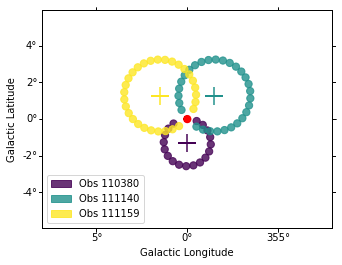

In [24]:
bkg_estimator = ReflectedRegionsBackgroundEstimator(
    obs_list=obs_list,
    on_region=on_region,
    exclusion_mask=exclusion_mask,
)
bkg_estimator.run()
bkg_estimate = bkg_estimator.result
bkg_estimator.plot()

In [25]:
extract = SpectrumExtraction(
    obs_list=obs_list,
    bkg_estimate=bkg_estimate,
)
extract.run()

### Model fit

The next step is to fit a spectral model, using all data (i.e. a "global" fit, using all energies).

In [26]:
model = models.PowerLaw(
    index = 2 * u.Unit(''),
    amplitude = 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
    reference = 1 * u.TeV,
)

fit = SpectrumFit(extract.observations, model)
fit.fit()
fit.est_errors()
print(fit.result[0])

/Users/deil/code/gammapy/gammapy/stats/fit_statistics.py:161: RuntimeWarning: divide by zero encountered in log
  term2_ = - n_on * np.log(mu_sig + alpha * mu_bkg)
/Users/deil/code/gammapy/gammapy/stats/fit_statistics.py:166: RuntimeWarning: divide by zero encountered in log
  term3_ = - n_off * np.log(mu_bkg)
/Users/deil/code/gammapy/gammapy/stats/fit_statistics.py:203: RuntimeWarning: divide by zero encountered in log
  term1 = - n_on * (1 - np.log(n_on))
/Users/deil/code/gammapy/gammapy/stats/fit_statistics.py:204: RuntimeWarning: divide by zero encountered in log
  term2 = - n_off * (1 - np.log(n_off))



Fit result info 
--------------- 
Model: PowerLaw

Parameters: 

	   name     value     error         unit      min max frozen
	--------- --------- --------- --------------- --- --- ------
	    index 2.226e+00 2.611e-02                 nan nan  False
	amplitude 3.019e-12 1.397e-13 1 / (cm2 s TeV) nan nan  False
	reference 1.000e+00 0.000e+00             TeV nan nan   True

Covariance: 

	name/name   index   amplitude
	--------- --------- ---------
	    index  0.000682 -9.96e-16
	amplitude -9.96e-16  1.95e-26 

Statistic: 91.257 (wstat)
Fit Range: [  1.00000000e-02   1.00000000e+02] TeV



### Spectral points

Finally, let's compute spectral points. The method used is to first choose an energy binning, and then to do a 1-dim likelihood fit / profile to compute the flux and flux error.

In [27]:
# Flux points are computed on stacked observation
stacked_obs = extract.observations.stack()
print(stacked_obs)

ebounds = EnergyBounds.equal_log_spacing(1, 40, 4, unit = u.TeV)

seg = SpectrumEnergyGroupMaker(obs=stacked_obs)
seg.compute_range_safe()
seg.compute_groups_fixed(ebounds=ebounds)

fpe = FluxPointEstimator(
    obs=stacked_obs,
    groups=seg.groups,
    model=fit.result[0].model,
)
fpe.compute_points()
fpe.flux_points.table

*** Observation summary report ***
Observation Id: [110380-111159]
Livetime: 1.470 h
On events: 2377
Off events: 34781
Alpha: 0.041
Bkg events in On region: 1432.16
Excess: 944.84
Excess / Background: 0.66
Gamma rate: 0.15 1 / min
Bkg rate: 0.23 1 / min
Sigma: 22.24
energy range: 0.01 TeV - 100.00 TeV


/Users/deil/code/gammapy/gammapy/stats/poisson.py:383: RuntimeWarning: divide by zero encountered in double_scalars
  temp = (alpha + 1) / (n_on + n_off)
/Users/deil/code/gammapy/gammapy/stats/poisson.py:384: RuntimeWarning: divide by zero encountered in log
  l = n_on * log(n_on * temp / alpha)
/Users/deil/code/gammapy/gammapy/stats/fit_statistics.py:161: RuntimeWarning: divide by zero encountered in log
  term2_ = - n_on * np.log(mu_sig + alpha * mu_bkg)
/Users/deil/code/gammapy/gammapy/stats/fit_statistics.py:166: RuntimeWarning: divide by zero encountered in log
  term3_ = - n_off * np.log(mu_bkg)
/Users/deil/code/gammapy/gammapy/stats/fit_statistics.py:203: RuntimeWarning: divide by zero encountered in log
  term1 = - n_on * (1 - np.log(n_on))
/Users/deil/code/gammapy/gammapy/stats/fit_statistics.py:204: RuntimeWarning: divide by zero encountered in log
  term2 = - n_off * (1 - np.log(n_off))


e_ref,e_min,e_max,dnde,dnde_err,dnde_ul,is_ul,sqrt_ts,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,bool,float64,float64,float64
1.56474814166,1.0,2.44843674682,1.09929677082e-12,1.23399567803e-13,1.36112562438e-12,False,13.9252559708,1.26220310761e-13,1.21722152847e-13
3.83118684956,2.44843674682,5.99484250319,1.57115663963e-13,1.94350698019e-14,1.9835646019e-13,False,13.6831790276,1.98236158774e-14,1.86031714233e-14
9.3804186664,5.99484250319,14.6779926762,1.30447549626e-14,3.09086142947e-15,2.00964479695e-14,False,6.83528872,3.32268015634e-15,2.88496727552e-15
22.9673617634,14.6779926762,35.938136638,1.27557550214e-15,5.70818610801e-16,2.7176911792e-15,False,3.55481035321,6.49472424329e-16,5.04683615003e-16


### Plot

Let's plot the spectral model and points. You could do it directly, but there is a helper class.
Note that a spectral uncertainty band, a "butterfly" is drawn, but it is very thin, i.e. barely visible.

(<matplotlib.axes._subplots.AxesSubplot at 0x10b8bebe0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10b2c67f0>)

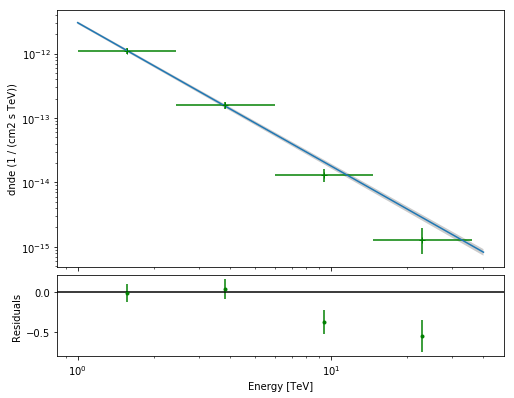

In [28]:
total_result = SpectrumResult(
    model=fit.result[0].model,
    points=fpe.flux_points,
)

total_result.plot(
    energy_range = [1, 40] * u.TeV,
    fig_kwargs=dict(figsize=(8,8)),
    point_kwargs=dict(color='green'),
)

## Exercises

* Re-run the analysis above, varying some analysis parameters, e.g.
    * Select a few other observations
    * Change the energy band for the map
    * Change the spectral model for the fit
    * Change the energy binning for the spectral points
* Change the target. Make a sky image and spectrum for your favourite source.
    * If you don't know any, the Crab nebula is the "hello world!" analysis of gamma-ray astronomy.

In [29]:
# print('hello world')
# SkyCoord.from_name('crab')

## What next?

* This notebook showed an example of a first CTA analysis with Gammapy, using simulated 1DC data.
* This was part 2 for CTA 1DC turorial, the first part was here: [cta_1dc_introduction.ipynb](cta_1dc_introduction.ipynb)
* More tutorials (not 1DC or CTA specific) with Gammapy are [here](../index.ipynb)
* Let us know if you have any question or issues!